In [19]:
# ---------------------------------------------------------
# GOOGLE COLAB SETUP
# ---------------------------------------------------------
import sys
import os
import subprocess
import re

# Check if running in Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Detected Google Colab environment.")
    
    # ---------------------------------------------------------
    # 1. Smart Installation Check
    # ---------------------------------------------------------
    # We check the installed NumPy version via pip *before* deciding to install.
    # This prevents the cell from hanging on re-runs after a restart.
    
    current_numpy_version = "0.0.0"
    try:
        # Run 'pip show numpy' to get the version on disk
        res = subprocess.run([sys.executable, "-m", "pip", "show", "numpy"], capture_output=True, text=True)
        m = re.search(r"Version:\s*(\d+\.\d+\.\d+)", res.stdout)
        if m:
            current_numpy_version = m.group(1)
    except Exception:
        pass

    print(f"Current NumPy version on disk: {current_numpy_version}")
    
    # Determine if we need to install/downgrade
    needs_install = False
    
    # Condition 1: NumPy must be 1.x
    if not current_numpy_version.startswith("1."):
        print("NumPy 2.x (or unknown) detected. Downgrade required.")
        needs_install = True
    else:
        # Condition 2: Check if energyflow/geomloss are installed
        res_pkg = subprocess.run([sys.executable, "-m", "pip", "show", "energyflow"], capture_output=True, text=True)
        if "Name: energyflow" not in res_pkg.stdout:
            print("energyflow not found. Installation required.")
            needs_install = True

    if needs_install:
        print("Installing required packages (this may take a minute)...")
        # AGGRESSIVE COMPATIBILITY FIX:
        # Force reinstall to ensure we get numpy<2.0.0 and compatible scipy/sklearn
        # Added geomloss for GPU OT
        !pip install -q -U --force-reinstall "numpy<2.0.0" "scipy<1.13.0" "scikit-learn<1.5.0" energyflow pot uproot awkward vector geomloss
        
        print("\n" + "="*80)
        print("INSTALLATION COMPLETE.")
        print("CRITICAL: You MUST restart the Colab runtime now.")
        print("1. Go to menu: Runtime > Restart session")
        print("2. Run this cell again (it will skip installation next time)")
        print("="*80 + "\n")
    else:
        print("Environment appears correct (NumPy 1.x installed). Skipping installation.")

    # ---------------------------------------------------------
    # 2. Download Dataset
    # ---------------------------------------------------------
    folder_id = '1VUMLowF7QLuBXKnTOQRSgU_T7jj4nI7X'
    output_folder = 'efjets'
    
    if not os.path.exists(output_folder):
        print(f"Downloading dataset to {output_folder}/...")
        !pip install -q -U --no-cache-dir gdown --pre
        import gdown
        gdown.download_folder(id=folder_id, output=output_folder, quiet=False)
    else:
        print(f"Folder '{output_folder}' already exists. Skipping download.")
        
else:
    print("Not running in Google Colab. Assuming local environment.")

Not running in Google Colab. Assuming local environment.


In [20]:
# Setup and Imports
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

# CRITICAL: Check NumPy version before importing other libraries
print(f"NumPy version: {np.__version__}")
if np.__version__ >= '2.0.0':
    msg = (
        f"Detected NumPy {np.__version__}, but this notebook requires NumPy < 2.0.0.\n"
        "Please run the 'GOOGLE COLAB SETUP' cell above to install the correct versions,\n"
        "then RESTART the runtime (Runtime > Restart session) and run this cell again."
    )
    raise RuntimeError(msg)

import ot
import energyflow as ef
from sklearn.manifold import TSNE

print("Libraries imported successfully.")

NumPy version: 1.26.4
Libraries imported successfully.


## 1. Data Loading: EnergyFlow Datasets

We will load jets from the `efjets/` directory.
*   **Quark Jets:** From `QG_jets` files (Label 1).
*   **Gluon Jets:** From `QG_jets` files (Label 0).
*   **Top Jets:** From `top_qcd` files (Label 1).

The data format is `(N, M, 4)` where features are `(pt, y, phi, pid)`.

In [24]:
# Data Loading Logic

# Define classes for our analysis
# We will map original labels to these new IDs
# 0: Gluon
# 1: Quark
# 2: Top
class_names = {
    0: 'Gluon',
    1: 'Quark',
    2: 'Top'
}

def preprocess_jets(X, y, source_type, max_jets=1000, max_particles=128):
    """
    Convert (N, M, 4) array to list of (M, 2) coordinates and weights.
    source_type: 'QG' or 'Top' to handle label mapping.
    """
    jets_X = []
    jets_w = []
    jets_pt = []
    labels = []
    
    count = 0
    for i in range(len(X)):
        if count >= max_jets:
            break
            
        # Extract features: (pt, y, phi, pid)
        # We use y (rapidity) and phi
        jet_data = X[i]
        
        # Filter zero-padded particles (pt=0)
        mask = jet_data[:, 0] > 0
        if np.sum(mask) < 2: continue # Skip empty/single particle jets
        
        pts = jet_data[mask, 0]
        ys  = jet_data[mask, 1]
        phis = jet_data[mask, 2]
        
        # Store total pT before normalization
        total_pt = pts.sum()
        
        # Limit particles
        if len(pts) > max_particles:
            # Sort by pt descending
            idx = np.argsort(pts)[::-1][:max_particles]
            pts = pts[idx]
            ys = ys[idx]
            phis = phis[idx]
            
        # Centering
        # Note: phi periodicity is handled by centering if the jet is localized
        # For safety, we can re-wrap phi after centering, but usually not strictly necessary for small R jets
        y_avg = np.average(ys, weights=pts)
        
        # Circular mean for phi
        phi_avg = np.arctan2(np.average(np.sin(phis), weights=pts), 
                             np.average(np.cos(phis), weights=pts))
                             
        ys_centered = ys - y_avg
        phis_centered = phis - phi_avg
        
        # Wrap phi to [-pi, pi]
        phis_centered = (phis_centered + np.pi) % (2 * np.pi) - np.pi
        
        # Construct (N, 2) array
        X_i = np.stack([ys_centered, phis_centered], axis=1)
        
        # Weights (normalized pT)
        w_i = pts / pts.sum()
        
        # Determine Label
        original_label = int(y[i])
        new_label = -1
        
        if source_type == 'QG':
            # Original: 0=Gluon, 1=Quark
            # Map: 0->0 (Gluon), 1->1 (Quark)
            new_label = original_label
        elif source_type == 'Top':
            # Original: 0=QCD, 1=Top
            # We only want Top (1)
            if original_label == 1:
                new_label = 2 # Top
            else:
                continue # Skip QCD from this file
        
        jets_X.append(X_i)
        jets_w.append(w_i)
        jets_pt.append(total_pt)
        labels.append(new_label)
        count += 1
        
    return jets_X, jets_w, labels, jets_pt

def load_ef_data(max_jets_per_class=250):
    all_X = []
    all_w = []
    all_labels = []
    all_pt = []
    
    # 1. Load QG Jets
    qg_files = glob.glob('efjets/QG_jets_*.npz')
    print(f"Found {len(qg_files)} QG files.")
    
    jets_needed = max_jets_per_class * 2 # Gluon + Quark
    jets_loaded = 0
    
    for f in qg_files:
        if jets_loaded >= jets_needed: break
        print(f"Loading {f}...")
        data = np.load(f)
        # QG files use 'X' and 'y'
        X_raw = data['X']
        y_raw = data['y'] # 0=Gluon, 1=Quark
        
        # We want roughly equal mix, so let's just load and filter later or load enough
        # Simple approach: Load chunk, process
        X_proc, w_proc, l_proc, pt_proc = preprocess_jets(X_raw, y_raw, 'QG', max_jets=jets_needed)
        
        all_X.extend(X_proc)
        all_w.extend(w_proc)
        all_labels.extend(l_proc)
        all_pt.extend(pt_proc)
        jets_loaded += len(X_proc)

    # 2. Load Top Jets
    top_files = glob.glob('efjets/top_qcd_*.npz')
    print(f"Found {len(top_files)} Top/QCD files.")
    
    jets_needed_top = max_jets_per_class
    jets_loaded_top = 0
    
    for f in top_files:
        if jets_loaded_top >= jets_needed_top: break
        print(f"Loading {f}...")
        data = np.load(f)
        
        # FIX: Check for keys, as top_qcd files might use 'data'/'labels'
        if 'data' in data:
            X_raw = data['data']
            y_raw = data['labels']
        else:
            X_raw = data['X']
            y_raw = data['y']
        
        X_proc, w_proc, l_proc, pt_proc = preprocess_jets(X_raw, y_raw, 'Top', max_jets=jets_needed_top*4) # Load more to find Tops
        
        all_X.extend(X_proc)
        all_w.extend(w_proc)
        all_labels.extend(l_proc)
        all_pt.extend(pt_proc)
        jets_loaded_top += len(l_proc)

    # Subsample to balance classes exactly
    final_X = []
    final_w = []
    final_labels = []
    final_pt = []
    
    arr_labels = np.array(all_labels)
    
    for cls_id in [0, 1, 2]:
        indices = np.where(arr_labels == cls_id)[0]
        if len(indices) > max_jets_per_class:
            indices = np.random.choice(indices, max_jets_per_class, replace=False)
        
        print(f"Class {class_names[cls_id]}: {len(indices)} jets")
        
        for idx in indices:
            final_X.append(all_X[idx])
            final_w.append(all_w[idx])
            final_labels.append(all_labels[idx])
            final_pt.append(all_pt[idx])
            
    return final_X, final_w, np.array(final_labels), np.array(final_pt)

# Load
jets_X, jets_w, labels, jets_pt = load_ef_data(max_jets_per_class=100)
N = len(jets_X)
print(f"Total jets loaded: {N}")

Found 2 QG files.
Loading efjets/QG_jets_1.npz...
Found 2 Top/QCD files.
Loading efjets/top_qcd_0.npz...
Class Gluon: 93 jets
Class Quark: 100 jets
Class Top: 100 jets
Total jets loaded: 293


In [25]:
# Visualization & Utility Functions

def plot_jet_scatter(ax, x0, y0, X, w, scale=0.25, max_markersize=60, cmap='viridis', alpha=0.8):
    xs = x0 + X[:, 0] * scale
    ys = y0 + X[:, 1] * scale
    s = (w / (w.max() + 1e-12)) * max_markersize
    ax.scatter(xs, ys, s=s, c=w, cmap=cmap, alpha=alpha, edgecolors='none')

print("Visualization utilities defined.")

Visualization utilities defined.


In [26]:
# ---------------------------------------------------------
# OT COMPUTATION (GPU or CPU)
# ---------------------------------------------------------
import torch
import geomloss
import multiprocessing
from joblib import Parallel, delayed

# Check GPU
try:
    USE_GPU = torch.cuda.is_available()
    if USE_GPU:
        print(f"GPU detected: {torch.cuda.get_device_name(0)}")
    else:
        print("No GPU detected. Using CPU.")
except ImportError:
    USE_GPU = False
    print("Torch/GeomLoss not found. Using CPU.")

def compute_pairwise_matrix_gpu(jets_X, jets_w, max_particles=200):
    print("Preparing data for GPU...")
    # Clear cache to free up fragmented memory
    torch.cuda.empty_cache()
    
    N = len(jets_X)
    
    # Pad jets to fixed size
    X_pad = np.zeros((N, max_particles, 2), dtype=np.float32)
    w_pad = np.zeros((N, max_particles), dtype=np.float32)
    
    for i in range(N):
        n_p = min(len(jets_X[i]), max_particles)
        X_pad[i, :n_p] = jets_X[i][:n_p]
        w_pad[i, :n_p] = jets_w[i][:n_p]
        w_sum = w_pad[i].sum()
        if w_sum > 0: w_pad[i] /= w_sum

    X_dev = torch.tensor(X_pad).cuda()
    w_dev = torch.tensor(w_pad).cuda()
    
    loss = geomloss.SamplesLoss("sinkhorn", p=2, blur=0.05)
    
    print("Computing pairwise matrix on GPU...")
    D_matrix = np.zeros((N, N))
    
    # Reduced batch size to prevent OOM
    # We compute distances from 'batch_size' jets to ALL 'N' jets at once.
    # With N=1500, batch_size=2 means 3000 pairs per step.
    batch_size = 2
    
    for i in range(0, N, batch_size):
        end = min(i + batch_size, N)
        B_curr = end - i
        
        X_batch = X_dev[i:end]
        w_batch = w_dev[i:end]
        
        Xi_flat = X_batch.repeat_interleave(N, dim=0)
        wi_flat = w_batch.repeat_interleave(N, dim=0)
        
        Xj_flat = X_dev.repeat(B_curr, 1, 1)
        wj_flat = w_dev.repeat(B_curr, 1) 
        
        L_flat = loss(wi_flat, Xi_flat, wj_flat, Xj_flat)
        L_mat = L_flat.view(B_curr, N)
        
        D_matrix[i:end, :] = L_mat.detach().cpu().numpy()
        
        if i % 100 == 0:
            print(f"Computed rows {i} to {end} of {N}...")
            # Aggressively clear cache during loop
            torch.cuda.empty_cache()
            
    return D_matrix

def compute_ot_pair_cpu(i, j):
    Xi, wi = jets_X[i], jets_w[i]
    Xj, wj = jets_X[j], jets_w[j]
    
    # Use Sinkhorn to match GPU implementation
    M = ot.dist(Xi, Xj, metric='euclidean')
    reg = 0.05 
    val = ot.sinkhorn2(wi, wj, M, reg)
    if isinstance(val, np.ndarray): val = val.item()
    return i, j, float(val)

if USE_GPU:
    print("Using GPU-accelerated Sinkhorn (GeomLoss)...")
    D = compute_pairwise_matrix_gpu(jets_X, jets_w)
else:
    print("Computing pairwise Sinkhorn distances using CPU parallel processing...")
    N = len(jets_X)
    n_cores = min(8, multiprocessing.cpu_count())
    pairs = [(i, j) for i in range(N) for j in range(i+1, N)]
    print(f"Total pairs to compute: {len(pairs)}")
    
    results = Parallel(n_jobs=n_cores, verbose=5)(
        delayed(compute_ot_pair_cpu)(i, j) for i, j in pairs
    )

    D = np.zeros((N, N))
    for i, j, val in results:
        D[i, j] = val
        D[j, i] = val
    np.fill_diagonal(D, 0.0)

No GPU detected. Using CPU.
Computing pairwise Sinkhorn distances using CPU parallel processing...
Total pairs to compute: 42778


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done  64 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done 2384 tasks      | elapsed:    5.5s
[Parallel(n_jobs=8)]: Done 10128 tasks      | elapsed:   12.6s
[Parallel(n_jobs=8)]: Done 14016 tasks      | elapsed:   17.3s
[Parallel(n_jobs=8)]: Done 18768 tasks      | elapsed:   23.0s
[Parallel(n_jobs=8)]: Done 24384 tasks      | elapsed:   30.2s
[Parallel(n_jobs=8)]: Done 30864 tasks      | elapsed:   39.8s
[Parallel(n_jobs=8)]: Done 38208 tasks      | elapsed:   54.4s
[Parallel(n_jobs=8)]: Done 42778 out of 42778 | elapsed:  1.1min finished


Running t-SNE for Q/G jets only (193 jets)...


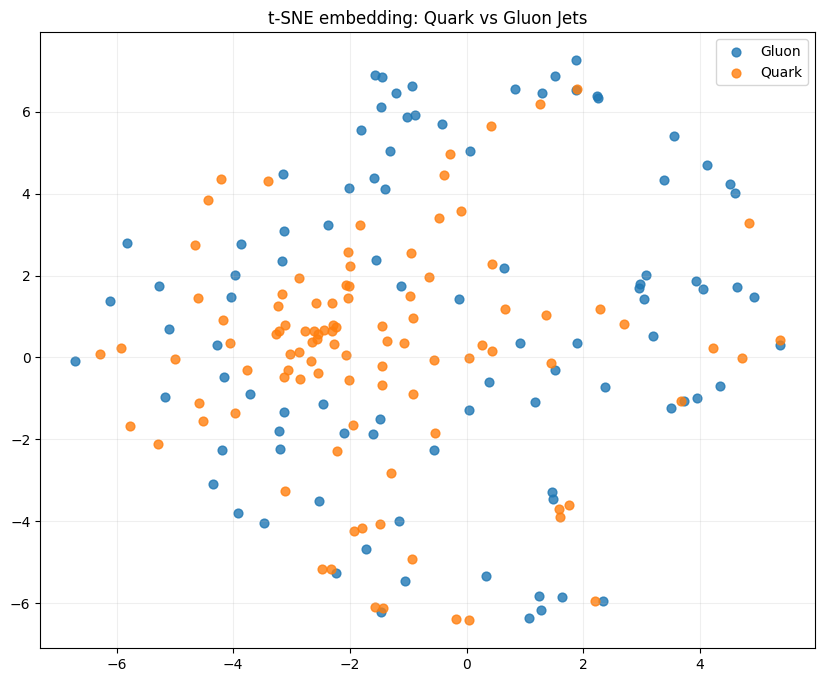

Running t-SNE for all classes...


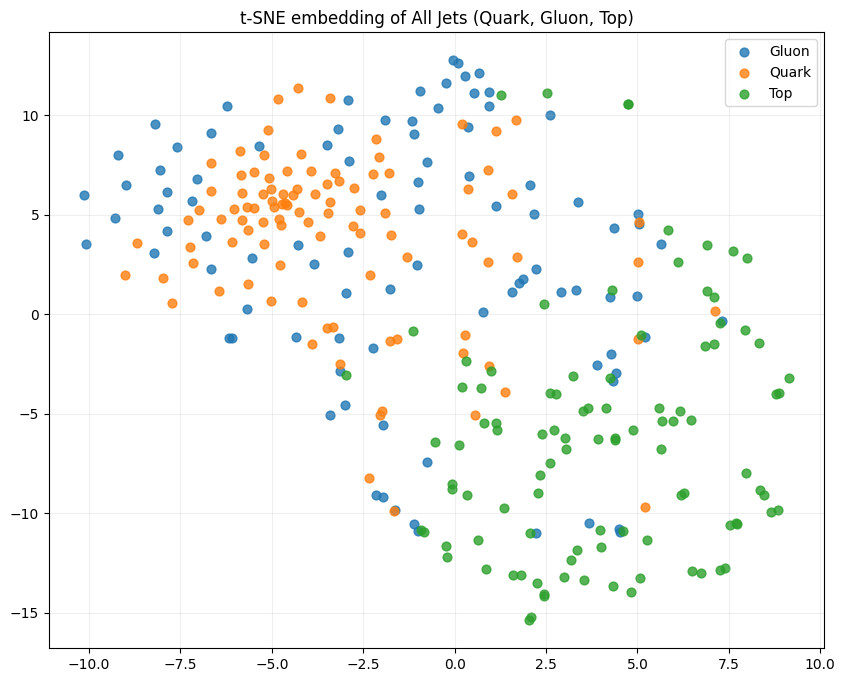

In [37]:
# ---------------------------------------------------------
# ANALYSIS & PLOTS
# ---------------------------------------------------------

# ---------------------------------------------------------
# 1. Q/G Only t-SNE
# ---------------------------------------------------------
# Filter for Quark (1) and Gluon (0) only
qg_indices = np.where((labels == 0) | (labels == 1))[0]

if len(qg_indices) > 0:
    print(f"Running t-SNE for Q/G jets only ({len(qg_indices)} jets)...")
    
    # Extract submatrix
    D_qg = D[np.ix_(qg_indices, qg_indices)]
    labels_qg = labels[qg_indices]
    
    # Run t-SNE
    tsne_qg = TSNE(n_components=2, metric='precomputed', init='random', random_state=42, perplexity=30)
    emb_qg = tsne_qg.fit_transform(D_qg)
    
    # Plot
    plt.figure(figsize=(10, 8))
    for i in [0, 1]: # Gluon, Quark
        if i in labels_qg:
            mask = labels_qg == i
            plt.scatter(emb_qg[mask, 0], emb_qg[mask, 1], label=class_names[i], s=40, alpha=0.8)
            
    plt.title('t-SNE embedding: Quark vs Gluon Jets')
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()
else:
    print("No Q/G jets found for separate plot.")

# ---------------------------------------------------------
# 2. Full t-SNE (All Classes)
# ---------------------------------------------------------
print("Running t-SNE for all classes...")
tsne = TSNE(n_components=2, metric='precomputed', init='random', random_state=42, perplexity=30)
emb = tsne.fit_transform(D)

# Plot 1: Standard t-SNE with consistent legend
plt.figure(figsize=(10, 8))
present_classes = np.unique(labels)
colors = plt.cm.tab10(np.linspace(0, 1, 10))

for i in present_classes:
    mask = labels == i
    plt.scatter(emb[mask, 0], emb[mask, 1], label=class_names[i], s=40, alpha=0.8)

plt.title('t-SNE embedding of All Jets (Quark, Gluon, Top)')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()


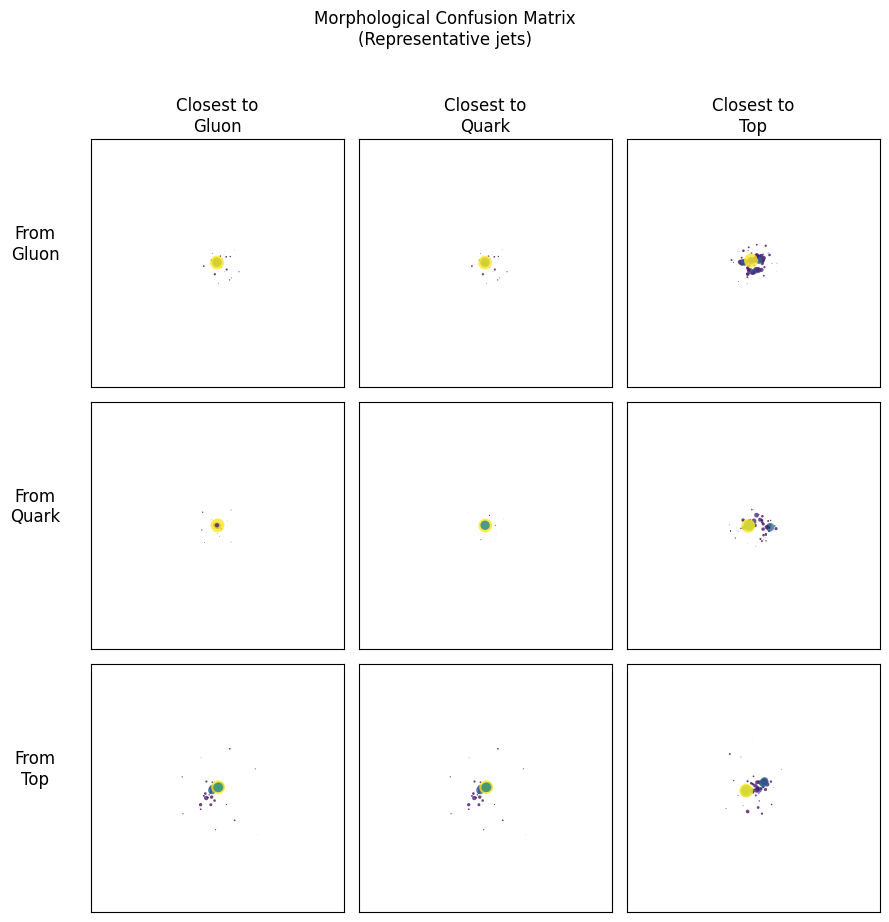

In [33]:

# Plot 3: Morphological Confusion Matrix
# For each class i, show the i-sample closest to class j on average
n_classes = len(present_classes)
if n_classes > 1:
    plt.figure(figsize=(9, 9))
    for i_idx, i in enumerate(present_classes):
        inds_i = np.where(labels == i)[0]
        for j_idx, j in enumerate(present_classes):
            inds_j = np.where(labels == j)[0]
            
            # Submatrix of distances between class i and class j
            dsub = D[np.ix_(inds_i, inds_j)]
            
            # Find the jet in class i that has the minimum average distance to all jets in class j
            avg_dist = dsub.mean(axis=1)
            best_local_idx = np.argmin(avg_dist)
            best_global_idx = inds_i[best_local_idx]
            
            ax = plt.subplot(n_classes, n_classes, i_idx * n_classes + j_idx + 1)
            plot_jet_scatter(ax, 0, 0, jets_X[best_global_idx], jets_w[best_global_idx], scale=0.5, max_markersize=100)
            ax.set_xlim(-1.0, 1.0); ax.set_ylim(-1.0, 1.0)
            ax.set_xticks([]); ax.set_yticks([])
            
            if i_idx == 0:
                plt.title(f"Closest to\n{class_names[j]}", fontsize=12)
            if j_idx == 0:
                plt.ylabel(f"From\n{class_names[i]}", fontsize=12, rotation=0, labelpad=40)

    plt.suptitle('Morphological Confusion Matrix\n(Representative jets)', y=1.02)
    plt.tight_layout()
    plt.show()



Generating absolute jet mass plot...


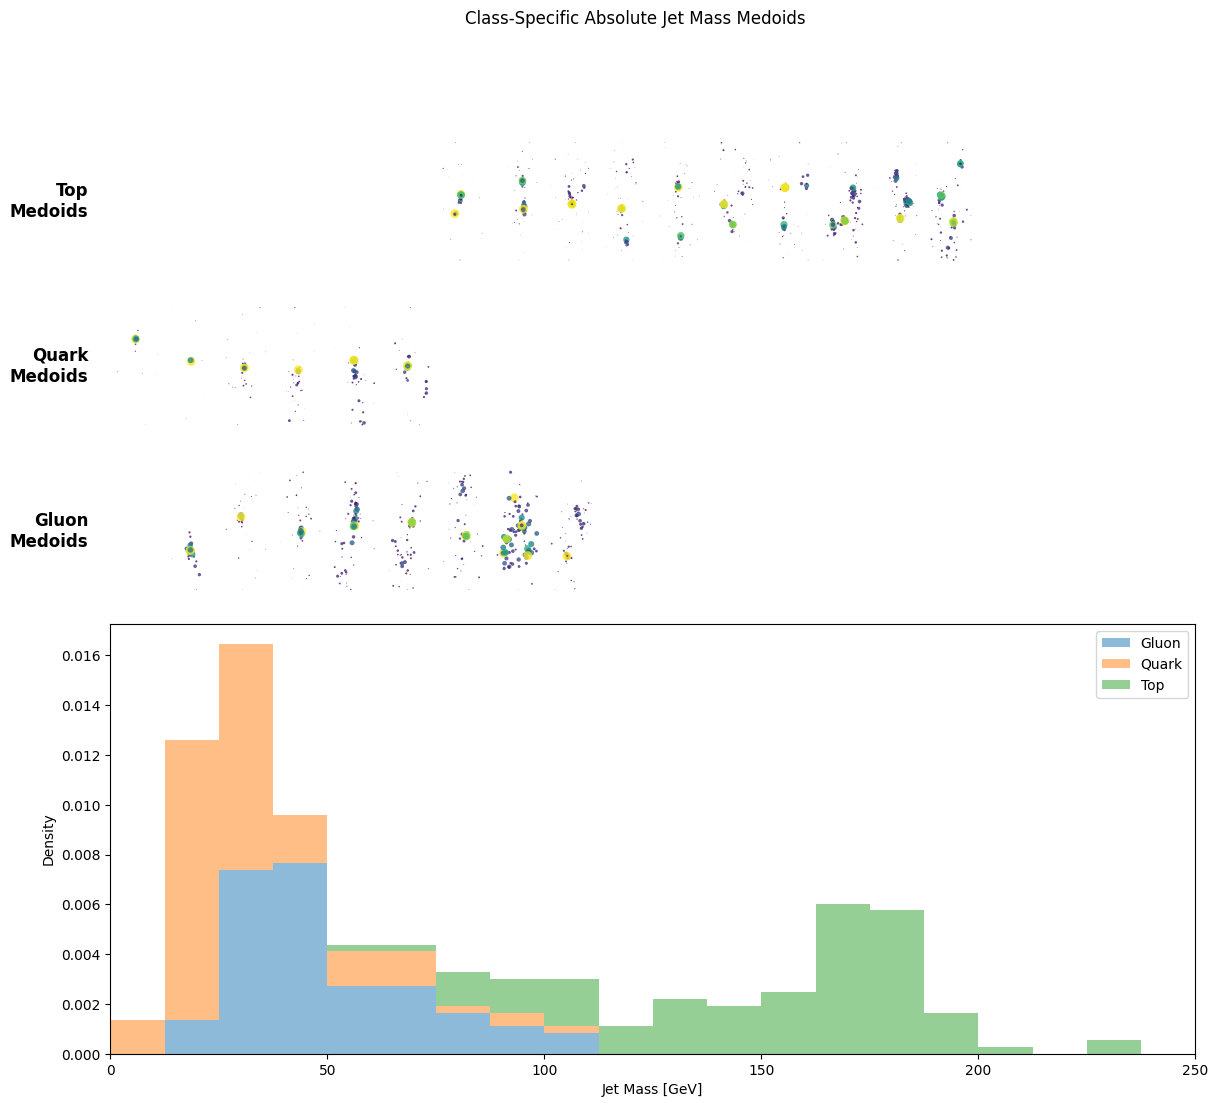

In [34]:
# Absolute Jet Mass Distribution with Medoids
# Note: This requires jets_pt to be available (re-run Data Loading if needed)

if 'jets_pt' not in locals():
    raise RuntimeError(
        "Variable 'jets_pt' is missing!\n"
        "Please perform the following steps:\n"
        "1. Re-run the 'Data Loading Logic' cell (Cell 3) to load pT info.\n"
        "2. Re-run the 'OT Computation' cell (Cell 4) to update the distance matrix for the new jets.\n"
        "3. Run this cell again."
    )

print("Generating absolute jet mass plot...")

# Calculate absolute mass: m = (m/pt) * pt
abs_masses = masses * jets_pt

fig = plt.figure(figsize=(14, 12))
plot_classes = [c for c in [2, 1, 0] if c in present_classes]
n_rows = len(plot_classes) + 1
height_ratios = [1]*len(plot_classes) + [3]

gs = fig.add_gridspec(n_rows, 1, height_ratios=height_ratios, hspace=0.1)

# Histogram (Bottom)
ax_hist = fig.add_subplot(gs[-1])
# Range: 0 to 250 GeV (typical for these datasets)
counts, bins, _ = ax_hist.hist([abs_masses[labels==i] for i in present_classes], 
                               bins=20, range=(0, 250), 
                               stacked=True, density=True, alpha=0.5, 
                               label=[class_names[i] for i in present_classes])
ax_hist.legend()
ax_hist.set_xlabel("Jet Mass [GeV]")
ax_hist.set_ylabel("Density")
ax_hist.set_xlim(0, 250)

# Medoid Rows
for row_idx, cls_id in enumerate(plot_classes):
    ax_row = fig.add_subplot(gs[row_idx], sharex=ax_hist)
    ax_row.axis('off')
    ax_row.set_xlim(0, 250)
    ax_row.set_ylim(-1, 1)
    
    ax_row.text(-0.02, 0.5, f"{class_names[cls_id]}\nMedoids", 
                transform=ax_row.transAxes, ha='right', va='center', fontsize=12, fontweight='bold')

    for k in range(len(bins)-1):
        mask = (abs_masses >= bins[k]) & (abs_masses < bins[k+1]) & (labels == cls_id)
        idxs = np.where(mask)[0]
        
        if len(idxs) > 2:
            d_sub = D[np.ix_(idxs, idxs)]
            medoid_local = np.argmin(d_sub.sum(axis=1))
            medoid_idx = idxs[medoid_local]
            
            x_c = (bins[k] + bins[k+1]) / 2
            x_norm = (x_c - 0) / 250.0
            
            ax_ins = inset_axes(ax_row, width="80%", height="90%", 
                               bbox_to_anchor=(x_norm - 0.5/20, 0, 1/20, 1), 
                               bbox_transform=ax_row.transAxes, loc='center')
            
            plot_jet_scatter(ax_ins, 0, 0, jets_X[medoid_idx], jets_w[medoid_idx], scale=0.8, max_markersize=40)
            ax_ins.set_xticks([])
            ax_ins.set_yticks([])
            ax_ins.axis('off')

plt.suptitle("Class-Specific Absolute Jet Mass Medoids")
plt.show()

Computing Fractal Correlation Dimensions...


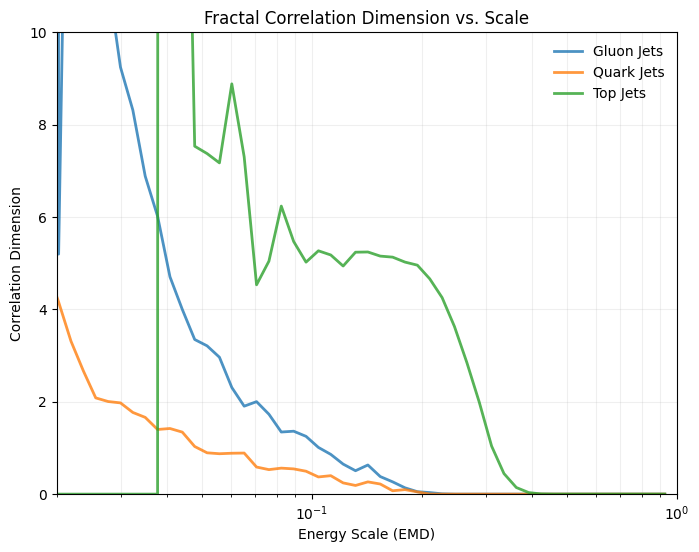

In [ ]:
# ---------------------------------------------------------
# FRACTAL CORRELATION DIMENSION
# ---------------------------------------------------------
# Based on EnergyFlow documentation
# We compute the correlation dimension of the dataset manifold
# by analyzing the distribution of pairwise distances.

print("Computing Fractal Correlation Dimensions...")

# Prepare bins for the histogram of distances (EMDs)
# Range: 10^-2 to 10^0 (0.01 to 1.0)
bins = 10**np.linspace(-2, 0, 60)
reg = 10**-30 # Regularization to avoid log(0)
midbins = (bins[:-1] + bins[1:])/2
dmidbins = np.log(midbins[1:]) - np.log(midbins[:-1]) + reg
midbins2 = (midbins[:-1] + midbins[1:])/2

plt.figure(figsize=(8, 6))

# Iterate over each class to compute its dimension
for i in present_classes:
    # Get indices for this class
    inds = np.where(labels == i)[0]
    
    # Extract sub-matrix of distances
    # We only need the upper triangle (excluding diagonal)
    # D is symmetric, so triu is sufficient.
    d_sub = D[np.ix_(inds, inds)]
    
    # Get upper triangle values (k=1 removes diagonal 0s)
    # Flatten to 1D array
    emd_vals = d_sub[np.triu_indices_from(d_sub, k=1)]
    
    # Compute histogram of distances
    # counts is the number of pairs with distance in each bin
    # We use cumsum because correlation sum C(r) is the fraction of pairs with dist < r
    hist_counts, _ = np.histogram(emd_vals, bins=bins)
    cdf_counts = np.cumsum(hist_counts)
    
    # Compute local slope of log(C(r)) vs log(r)
    # dim = d(log C(r)) / d(log r)
    dims = (np.log(cdf_counts[1:] + reg) - np.log(cdf_counts[:-1] + reg)) / dmidbins
    
    # Plot
    plt.plot(midbins2, dims, '-', label=f'{class_names[i]} Jets', alpha=0.8, linewidth=2)

# Styling
plt.xscale('log')
plt.xlabel('Energy Scale (EMD)')
plt.ylabel('Correlation Dimension')
plt.xlim(0.02, 1.0)
plt.ylim(0, 10)
plt.legend(loc='best', frameon=False)
plt.title('Fractal Correlation Dimension vs. Scale')
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.show()